In [2]:
import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical

torch.manual_seed(1)

[]

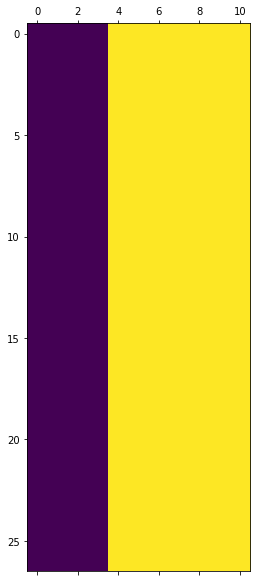

In [13]:
with open('../../results/attentions.pkl', 'rb') as f:
    attentions = pickle.load(f)
    
attentions = attentions.squeeze(1)

plt.matshow(attentions)
plt.plot()

In [1]:
from dataset import *

morph_data = MorphologyDatasetTask3(csv_file='../data/files/english_csv_test.csv', language='english', 
                                    root_dir='../data/files')

for i in range(len(morph_data)):
    sample = morph_data[i]
    
    print(sample)


hello
playing                                  trivial
pos=verb,tense=past,mod=ind    pos=adj,color=neg
played                                 untrivial
Name: 0, dtype: object
{'source_form': 'trivial', 'msd': pos=verb,tense=past,mod=ind    pos=adj,color=neg
Name: 0, dtype: object, 'target_form': 'untrivial'}
hello
playing                                              decided
pos=verb,tense=past,mod=ind    pos=verb,tense=present,mod=cc
played                                                decide
Name: 1, dtype: object
{'source_form': 'decided', 'msd': pos=verb,tense=past,mod=ind    pos=verb,tense=present,mod=cc
Name: 1, dtype: object, 'target_form': 'decide'}


In [2]:
def process_MSD(msd):
    '''
    Process msd in the input sentence
    Args:
        msd: string containing different MSDs
    Returns:
        out: dict with different msds
    '''
    
    out = {}
    msds = msd.strip().split(',')

    for m in msds:
        current = m.strip().split('=')
        out[current[0]] = current[1]

    return out

In [3]:
path = '../data/task1_test'

out  = []

with open(path, 'r', encoding='utf-8') as f:
    source = f.read()
    
sentences = source.strip().split('\n')

for sentence in sentences:
    line = sentence.strip().split('\t')
    
    if len(line) > 3:
        print('Something wrong with line: {}'.format(sentence))
        continue
    
    current_word = {
        'lemma'      : line[0],
        'MSD'        : process_MSD(line[1]),
        'target_form': line[2]        
    }
    
    out.append(current_word)

FileNotFoundError: [Errno 2] No such file or directory: '../data/task1_test'

In [ ]:
# print(out[0])
out

In [4]:
with open('../data/pickles/task3_test.pkl', 'rb') as f:
    n_out = pickle.load(f)

In [17]:
n_out

[{'source_form': 'playing',
  'MSD': {'pos': 'verb', 'tense': 'present', 'mod': 'ind'},
  'target_form': 'played'},
 {'source_form': 'trivial',
  'MSD': {'pos': 'adj', 'color': 'neg'},
  'target_form': 'untrivial'},
 {'source_form': 'decided',
  'MSD': {'pos': 'verb', 'tense': 'past', 'mod': 'cc'},
  'target_form': 'decide'}]

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6



{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [5]:
def load_file(path):
    '''
    load pickle File
    Args:
        path: file path
    Returns:
        out : pickle loaded
    '''

    with open(path, 'rb') as f:
        out = pickle.load(f)

    return out


In [10]:
with open('../data/pickles/desc_2_idx', 'rb') as f:
    desc_2_idx = pickle.load(f)
    
print(desc_2_idx)
print("---")

with open('../data/pickles/msd_options', 'rb') as f:
    msd_options = pickle.load(f)
    
print(msd_options)
print("---")

with open('../data/pickles/task3_test.pkl', 'rb') as f:
    task3_test = pickle.load(f)

print(task3_test)

{'pos': 0, 'tense': 1, 'mod': 2, 'color': 3}
---
{0: {'None': 0, 'verb': 1, 'adj': 2}, 1: {'None': 0, 'present': 1, 'past': 2}, 2: {'None': 0, 'ind': 1, 'cc': 2}, 3: {'None': 0, 'neg': 1}}
---
[{'source_form': 'playing', 'MSD': {'pos': 'verb', 'tense': 'present', 'mod': 'ind'}, 'target_form': 'played'}, {'source_form': 'trivial', 'MSD': {'pos': 'adj', 'color': 'neg'}, 'target_form': 'untrivial'}, {'source_form': 'decided', 'MSD': {'pos': 'verb', 'tense': 'past', 'mod': 'cc'}, 'target_form': 'decide'}]


In [54]:
def prepare_msd(msd, idx_2_desc, msd_options):
    '''
    msd: {'pos': 'verb', 'tense': 'present', 'mod': 'ind'}

    output: [0, 1, 2, 0, 0, ...]
    '''
    label_len = len(idx_2_desc)
    k_output  = []

    for i in range(label_len):
        desc  = idx_2_desc[i]
        opt   = msd.get(desc)
        types = msd_options[i]

        if opt is None:
            k_output.append(to_categorical([0], num_classes=len(types))[0])
            continue

        k_output.append(to_categorical([types[opt]], num_classes=len(types))[0])

    return np.concatenate(k_output, axis=0)

def prepare_sequence(sequence, char_2_idx, max_seq_len):
    '''
    Append <END> to each sequence and Pad with <PAD>
    '''
    output = []

    for char in sequence:
        output.append(char_2_idx[char])

    output.append(char_2_idx['<END>'])

    while len(output) < max_seq_len:
        output.append(char_2_idx['<PAD>'])

    return output

In [27]:
idx_2_desc  = load_file('../data/pickles/idx_2_desc')
char_2_idx  = load_file('../data/pickles/char_2_idx')
msd_options = load_file('../data/pickles/msd_options')

In [60]:
# msd = {'pos': 'verb', 'tense': 'present', 'mod': 'ind'}
# msd = {'pos': 'adj', 'color': 'neg'}
msd       = {'pos': 'verb', 'tense': 'past', 'mod': 'cc'}
labels    = prepare_msd(msd, idx_2_desc, msd_options)
data_test = prepare_sequence('playing', char_2_idx, 10)

print('labels    : {}'.format(labels))
print('data_test : {}'.format(data_test))
print('vocab size: {}'.format(len(char_2_idx)))

labels    : [0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
data_test : [0, 1, 2, 3, 4, 5, 6, 14, 15, 15]
vocab size: 16


In [125]:
x_s = torch.from_numpy(to_categorical(data_test, num_classes=len(char_2_idx)))
print(x_s.size())
print(x_s[0])

# x_s = torch.unsqueeze(x_s, 0)
# print(x_s.size())


print(F.log_softmax(x_s, dim=1))

torch.Size([10, 16])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[-1.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746,
         -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746],
        [-2.8746, -1.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746,
         -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746],
        [-2.8746, -2.8746, -1.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746,
         -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746],
        [-2.8746, -2.8746, -2.8746, -1.8746, -2.8746, -2.8746, -2.8746, -2.8746,
         -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746],
        [-2.8746, -2.8746, -2.8746, -2.8746, -1.8746, -2.8746, -2.8746, -2.8746,
         -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -2.8746],
        [-2.8746, -2.8746, -2.8746, -2.8746, -2.8746, -1.8746, -2.8746, -2.8746,
         -

In [112]:
m = torch.distributions.categorical.Categorical(torch.tensor([ 0.25, 0.25, 0.25, 0.25 ]))

sample = m.sample()

print(m.log_prob(sample))

tensor(-1.3863)
